In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

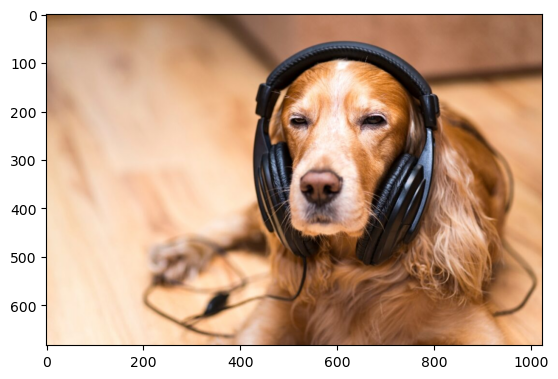

In [3]:
img = Image.open('/Users/kimhongseok/cv_79_projects/part1/chapter1/7/data/test/ai/221.jpg').convert('RGB')
plt.imshow(img)

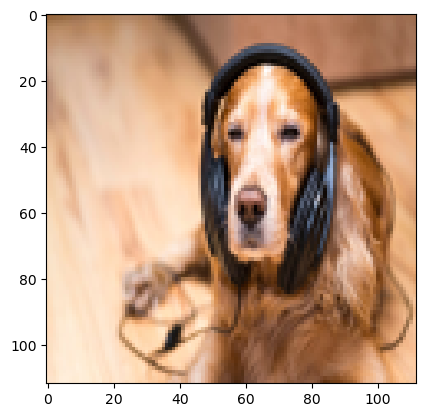

In [4]:
plt.imshow(img.resize((112, 112)))

# CustomDataset

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.root_path = root_path
        self.classes = classes
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_path = os.path.join(root_path, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                if img != '.DS_Store':
                    img_path = os.path.join(cls_path, img)
                    self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [6]:
classes = ['ai', 'real']
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/7/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/7/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/7/data/test', classes, transforms)

In [7]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

2568 482 40


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

In [9]:
train_dataset[1500][0]

tensor([[[0.2196, 0.2549, 0.2314,  ..., 0.1137, 0.1922, 0.2118],
         [0.0706, 0.0824, 0.0980,  ..., 0.1725, 0.2353, 0.1882],
         [0.1020, 0.0902, 0.1020,  ..., 0.2667, 0.5608, 0.2549],
         ...,
         [0.4118, 0.4000, 0.3922,  ..., 0.4902, 0.4824, 0.4784],
         [0.3882, 0.3804, 0.3882,  ..., 0.4510, 0.4549, 0.4510],
         [0.3608, 0.3804, 0.3882,  ..., 0.4157, 0.4353, 0.4275]],

        [[0.2745, 0.2784, 0.2353,  ..., 0.1490, 0.1922, 0.1804],
         [0.1412, 0.1373, 0.1373,  ..., 0.2275, 0.2667, 0.1961],
         [0.2039, 0.1961, 0.2039,  ..., 0.3255, 0.6196, 0.3098],
         ...,
         [0.4118, 0.4039, 0.3961,  ..., 0.5098, 0.5020, 0.4980],
         [0.3882, 0.3804, 0.3882,  ..., 0.4549, 0.4588, 0.4510],
         [0.3608, 0.3804, 0.3922,  ..., 0.4039, 0.4235, 0.4157]],

        [[0.2706, 0.2627, 0.2157,  ..., 0.1451, 0.2157, 0.2235],
         [0.1882, 0.1765, 0.1765,  ..., 0.2353, 0.3137, 0.2784],
         [0.2941, 0.2941, 0.3059,  ..., 0.3529, 0.6824, 0.

# training, evaluation

In [10]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [11]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=len(classes)
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [12]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/81 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.546323788754734, Train Accuracy: 0.7449376947040498, Valid Loss: 0.43132781982421875, Valid Accuracy: 0.8568464730290456


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4070924432189376, Train Accuracy: 0.8586448598130841, Valid Loss: 0.3526939544826746, Valid Accuracy: 0.9024896265560166


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3540637075533102, Train Accuracy: 0.8714953271028038, Valid Loss: 0.31270272843539715, Valid Accuracy: 0.9107883817427386


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.32123607525854936, Train Accuracy: 0.8851246105919003, Valid Loss: 0.2836801018565893, Valid Accuracy: 0.9149377593360996


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3004895364060814, Train Accuracy: 0.8936915887850467, Valid Loss: 0.27403896395117044, Valid Accuracy: 0.921161825726141


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.28640381311192925, Train Accuracy: 0.8968068535825545, Valid Loss: 0.2616429221816361, Valid Accuracy: 0.9253112033195021


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.27554853481275066, Train Accuracy: 0.897196261682243, Valid Loss: 0.2570929201319814, Valid Accuracy: 0.9232365145228216


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.26580812993608877, Train Accuracy: 0.9080996884735203, Valid Loss: 0.24149147234857082, Valid Accuracy: 0.9253112033195021


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2577099743080728, Train Accuracy: 0.9088785046728972, Valid Loss: 0.242798893712461, Valid Accuracy: 0.9273858921161826


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2512339163157675, Train Accuracy: 0.9100467289719626, Valid Loss: 0.23721675109118223, Valid Accuracy: 0.9356846473029046


# test

In [14]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        max_prob, preds = torch.max(probs, 1)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/161 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
from sklearn.metrics import f1_score

f1_score(total_labels, total_preds, average='macro')

0.9214531835205992

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    label = total_labels[i]
    pred = total_preds[i]
    plt.title()